# Numpy neural network

In [177]:
import numpy as np
import gzip

## 1. Unpackaged .gz file

In [178]:
url_train_image = "Fashion_MNIST_data/train-images-idx3-ubyte.gz"
url_train_labels = "Fashion_MNIST_data/train-labels-idx1-ubyte.gz"
url_test_image = "Fashion_MNIST_data/t10k-images-idx3-ubyte.gz"
url_test_labels = "Fashion_MNIST_data/t10k-labels-idx1-ubyte.gz"

In [179]:
def load_data():
    path_list = [url_train_image, url_train_labels, url_test_image, url_test_labels]
    with gzip.open(path_list[0], 'rb') as f:
        x_train = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28*28)/255.0
    with gzip.open(path_list[1], 'rb') as f:
        y_train = np.frombuffer(f.read(), np.uint8, offset=8)
    with gzip.open(path_list[2], 'rb') as f:
        x_test = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28*28)/255.0
    with gzip.open(path_list[3], 'rb') as f:
        y_test = np.frombuffer(f.read(), np.uint8, offset=8)
        
    return (x_train, y_train), (x_test, y_test)
    

In [180]:
(X_train, y_train), (x_test, y_test) = load_data()

In [181]:
print(y_test.shape)

(10000,)


## 2. Define Model

In [183]:
class FFNN:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
        
        # Initialize weights and biases for the first hidden layer
        # self.W1 = np.random.randn(self.input_size, self.hidden_size1)
        # use normal distribution to initialize weights
        self.W1 = np.random.normal(0.0, pow(self.input_size, -0.5), (self.input_size, self.hidden_size1))
        self.b1 = np.zeros(self.hidden_size1)
        
        # Initialize weights and biases for the second hidden layer
        # self.W2 = np.random.randn(self.hidden_size1, self.hidden_size2)
        self.W2 = np.random.normal(0.0, pow(self.hidden_size1, -0.5), (self.hidden_size1, self.hidden_size2))
        self.b2 = np.zeros(self.hidden_size2)
        
        # Initialize weights and biases for the output layer
        # self.W3 = np.random.randn(self.hidden_size2, self.output_size)
        self.W3 = np.random.normal(0.0, pow(self.hidden_size2, -0.5), (self.hidden_size2, self.output_size))
        self.b3 = np.zeros(self.output_size)
        
        self.train_loss = []
        self.train_score = []
        self.test_loss = []
        self.test_score = []
        
    def forward(self, X):
        # Forward pass through the network
        
        ## Note: np.dot(X, self.W1) size is (N, hidden_size1),
        ## self.b1 size is (hidden_size1)
        ## so self.b1 will be broadcasted to the same shape as np.dot(X, self.W1)
        ## self.z1 size is (N, hidden_size1)
        
        self.z1 = np.dot(X, self.W1) + self.b1
        # self.a1 = self.relu(self.z1) 
        self.a1 = self.sigmoid(self.z1)
        
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        # self.a2 = self.relu(self.z2)
        self.a2 = self.sigmoid(self.z2)
        
        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.a3 = self.softmax(self.z3)
        
        return self.a3
    
    def relu(self, x):
        ## Note: 0 will be broadcasted to the same shape as x is (N, hidden_size) 
        ## np.maximun is element-wise to compare which one is bigger 
        ## reture size is the same as x
        return np.maximum(0, x)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def softmax(self, x):
        ## Note1: 
        ## x size is (N, output_size)
        ## we need to sum over the second dimension, so we set axis=1, size is (N, 1)
        ## and np.exp(x) size is (N, output_size)
        ## so np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True) size is (N, output_size)
        ## division here is broadcasted over the first dimension too
        
        # exp_x = np.exp(x)
        # return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
        ## Note2: 
        ## subtracting the maximum value along the axis
        ## is to prevent overflow when exponentiating large values
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def cross_entropy_loss(self, y_ture, y_pred):
        ## Note 1:
        ## dividing by y_true.shape[0] (the number of samples in the batch) 
        ## is a normalization step to ensure that the loss is independent of the batch size.
        ## The loss function measures the average loss per sample in the batch.
        ## Note 2: 
        ## original y size is (N, 1), y_pred size is (N, output_size), 
        ## we need to change y to one-hot encoding.
        ## Note 3:
        ## np.sum(y_ture * np.log(y_pred)) at the beginning is nan
        ## because y_pred is nearly 0 at the beginning, and log(0) is not defined, so it is nan
        ## we need to add a small number to y_pred to avoid this problem
        epsilon = 1e-8
        return -np.sum(y_ture * np.log(y_pred + epsilon)) / y_ture.shape[0]
    
    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)
    
    def sigmoid_derivative(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    def backward(self, X, y_ture, lr=0.01):
        m = X.shape[0]
        
        # Output layer gradients
        ## Note: dL_dz3 is calculated by the derivative of cross entropy and softmax
        ## Note self.a3 size is (N, output_size), y_ture size is (N, output_size), dL_dz3 size is (N, output_size)
        dL_dz3 = (self.a3 - y_ture) / m
        ## Note: dL_dW3 is multiplied by backward and forward propagation
        ## self.a2.T size is (hidden_size2, N), dL_dz3 size is (N, output_size), dL_dW3 size is (hidden_size2, output_size)
        dL_dW3 = np.dot(self.a2.T, dL_dz3)
        dL_db3 = np.sum(dL_dz3, axis=0)
        
        # Hidden layer 2 gradients
        # self.W3.T size is (output_size, hidden_size2), dL_dz3 size is (N, output_size), dL_dz2 and self.z2 size is (N, hidden_size2)
        # dL_dz2 = np.dot(dL_dz3, self.W3.T) * self.relu_derivative(self.z2) / m
        dL_dz2 = np.dot(dL_dz3, self.W3.T) * self.sigmoid_derivative(self.z2) / m
        # self.a1.T size is (hidden_size1, N),  dL_dz2 size is (N, hidden_size2)
        dL_dW2 = np.dot(self.a1.T, dL_dz2)
        dL_db2 = np.sum(dL_dz2, axis=0)
        
        # Hidden layer 1 gradients
        # dL_dz1 = np.dot(dL_dz2, self.W2.T) * self.relu_derivative(self.z1) / m
        dL_dz1 = np.dot(dL_dz2, self.W2.T) * self.sigmoid_derivative(self.z1) / m
        dL_dW1 = np.dot(X.T, dL_dz1)
        dL_db1 = np.sum(dL_dz1, axis=0)
        
        # Update weights and biases
        self.W3 -= lr * dL_dW3
        self.b3 -= lr * dL_db3
        self.W2 -= lr * dL_dW2
        self.b2 -= lr * dL_db2
        self.W1 -= lr * dL_dW1
        self.b1 -= lr * dL_db1
    
    def precison(self, y_ture, y_pred):
        y_pred_labels = np.argmax(y_pred, axis=1)
        y_ture_labels = np.argmax(y_ture, axis=1)
        return np.sum(y_ture_labels == y_pred_labels) / len(y_ture)
        
    def train(self, X, y, x_test, y_test, epochs=100, lr=0.01, batch_size=32):
        for epoch in range(epochs):
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                
                y_pred = self.forward(X_batch)
                loss = self.cross_entropy_loss(y_batch, y_pred)
                score = self.precison(y_batch, y_pred)
                self.backward(X_batch, y_batch, lr)
                
            self.train_loss.append(loss)
            self.train_score.append(score)
            self.predict(x_test, y_test)
            
            if (epoch+1) % 10 == 0:
                print(f'Epoch {epoch+1}, \nTrain  loss {loss:.4f}, precision {score:.4f}')
        
        self.save_weights(f'Model/batch{batch_size}_epoch{epochs}_train{self.train_score[-1]}_test{self.test_score[-1]}_weights.npy')
            
        return self.train_loss, self.train_score, self.test_loss, self.test_score
                
                
    def predict(self, X, y):
        y_pred = self.forward(X)
        loss = self.cross_entropy_loss(y, y_pred)
        score = self.precison(y, y_pred)
        self.test_loss.append(loss)
        self.test_score.append(score)
        # print(f'Test Loss: {loss:.4f}, precision: {score:.4f}')
        
    def save_weights(self, file_path):
        # Save model weights to a .npy file
        weights = {
            "W1": self.W1,
            "b1": self.b1,
            "W2": self.W2,
            "b2": self.b2,
            "W3": self.W3,
            "b3": self.b3,
        }
        np.save(file_path, weights)

    def load_weights(self, file_path):
        # Load model weights from a .npy file
        weights = np.load(file_path, allow_pickle=True).item()
        self.W1 = weights["W1"]
        self.b1 = weights["b1"]
        self.W2 = weights["W2"]
        self.b2 = weights["b2"]
        self.W3 = weights["W3"]
        self.b3 = weights["b3"]
    

## 3. Train Model

In [184]:
INPUT_SIZE = 784
HIDDEN_SIZE1 = 392
HIDDEN_SIZE2 = 128
OUTPUT_SIZE = 10

LEARNING_RATE = 0.1
EPOCHS = 3000
BATCH_SIZE = 100

y_train_onehot = np.eye(OUTPUT_SIZE)[y_train]
y_test_onehot = np.eye(OUTPUT_SIZE)[y_test]

nn = FFNN(INPUT_SIZE, HIDDEN_SIZE1, HIDDEN_SIZE2, OUTPUT_SIZE)
train_loss, train_score, test_loss, test_score = nn.train(X_train, y_train_onehot, x_test, y_test_onehot, EPOCHS, LEARNING_RATE, BATCH_SIZE)


Epoch 10, 
Train  loss 1.2882, precision 0.6400
Epoch 20, 
Train  loss 0.9169, precision 0.6900
Epoch 30, 
Train  loss 0.7708, precision 0.7400
Epoch 40, 
Train  loss 0.6953, precision 0.7700
Epoch 50, 
Train  loss 0.6475, precision 0.8000
Epoch 60, 
Train  loss 0.6128, precision 0.8100
Epoch 70, 
Train  loss 0.5857, precision 0.8100
Epoch 80, 
Train  loss 0.5637, precision 0.8600
Epoch 90, 
Train  loss 0.5456, precision 0.8500
Epoch 100, 
Train  loss 0.5306, precision 0.8500
Epoch 110, 
Train  loss 0.5181, precision 0.8500
Epoch 120, 
Train  loss 0.5076, precision 0.8500
Epoch 130, 
Train  loss 0.4987, precision 0.8500
Epoch 140, 
Train  loss 0.4912, precision 0.8500
Epoch 150, 
Train  loss 0.4847, precision 0.8500
Epoch 160, 
Train  loss 0.4790, precision 0.8500
Epoch 170, 
Train  loss 0.4740, precision 0.8500
Epoch 180, 
Train  loss 0.4695, precision 0.8500
Epoch 190, 
Train  loss 0.4654, precision 0.8500
Epoch 200, 
Train  loss 0.4618, precision 0.8500
Epoch 210, 
Train  loss 0.458

## 4. Plot result

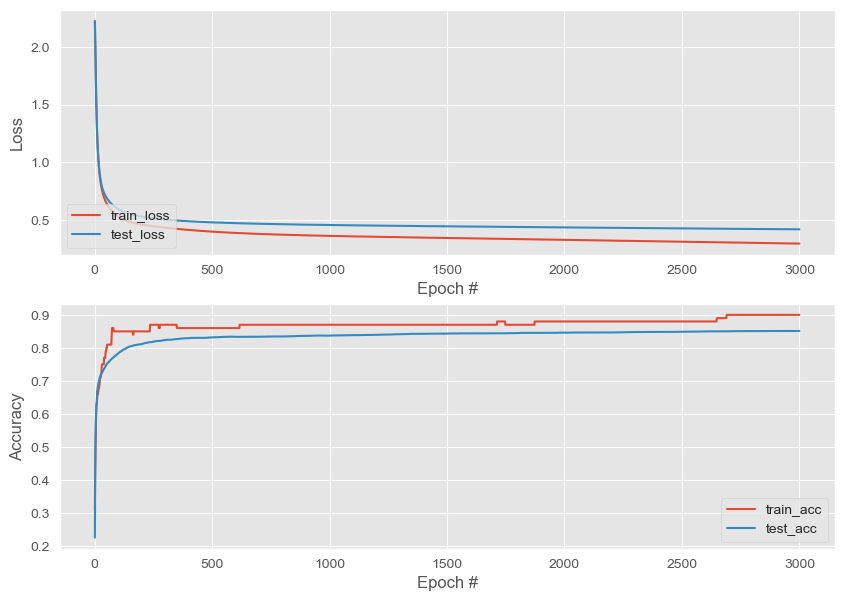

In [185]:
import matplotlib.pyplot as plt

# plot the training loss and accuracy
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(2,2,(1,2))
plt.style.use("ggplot")

plt.plot(range(1, EPOCHS+1), train_loss, label="train_loss")
plt.plot(range(1, EPOCHS+1), test_loss, label="test_loss")

plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

fig.add_subplot(2,2,(3,4))
plt.plot(range(1, EPOCHS+1), train_score, label="train_acc")
plt.plot(range(1, EPOCHS+1), test_score, label="test_acc")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="best")

plt.savefig(f'result_picture/batch{BATCH_SIZE}_epoch{EPOCHS}_train{train_score[-1]}_test{test_score[-1]}.png')


plt.show()